In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os

In [2]:
!pwd

/home/dsc/TFM/repositorio


In [3]:
data_root = "/home/dsc/TFM/repositorio/"

In [4]:
columns = ['user_id', 'rating', 'comida', 'id_comida' ]
datafile = os.path.join(data_root, "Encuesta_vf.csv")
data = pd.read_csv(datafile, sep=';', header =0, names=columns, encoding='latin-1')
data.head()

,user_id,rating,comida,id_comida
0,18,3,Ensalada de col con queso,4
1,33,1,Ensalada de col con queso,4
2,63,1,Ensalada de col con queso,4
3,64,2,Ensalada de col con queso,4
4,65,1,Ensalada de col con queso,4


In [5]:
n_users = data.user_id.unique().shape[0]
n_items = data.comida.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

1084 users
407 items


In [6]:
items_id = {}
food = data.comida.unique()
food_id = {}
n = 0
for x in food:
    items_id[x] = n
    food_id[n] = x
    n += 1

In [7]:
items_id['Puchero casero']

110

In [8]:
index = list(range(len(data.index)))

In [9]:
column_items_id=[]
for x in index:
    column_items_id.append(items_id[data['comida'][x]]) 

In [10]:
data['items_id'] = column_items_id

In [11]:
data.head()

,user_id,rating,comida,id_comida,items_id
0,18,3,Ensalada de col con queso,4,0
1,33,1,Ensalada de col con queso,4,0
2,63,1,Ensalada de col con queso,4,0
3,64,2,Ensalada de col con queso,4,0
4,65,1,Ensalada de col con queso,4,0


In [12]:
p_train = 0.70 # Porcentaje de train.

data['is_train'] = np.random.uniform(0, 1, len(data)) <= p_train
train, test = data[data['is_train']==True], data[data['is_train']==False]
data = data.drop('is_train', 1)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para test: ", len(test))

Ejemplos usados para entrenar:  29003
Ejemplos usados para test:  12511


In [13]:
ratings = np.zeros((n_users, n_items))
n_rating = len(train) + len(test)
sparsity = n_rating/(ratings.shape[0] * ratings.shape[1])
sparsity *=100
print (sparsity)

9.40959409594096


In [14]:
train.head()

,user_id,rating,comida,id_comida,items_id,is_train
0,18,3,Ensalada de col con queso,4,0,True
1,33,1,Ensalada de col con queso,4,0,True
2,63,1,Ensalada de col con queso,4,0,True
5,66,3,Ensalada de col con queso,4,0,True
6,70,1,Ensalada de col con queso,4,0,True


In [15]:
#Metricas de Evaluacion

In [16]:
class Metrics():
    """
    Implement the two most important relevance's metric for RS:
        . Recall
        . MAP
    """
    def __init__(self, train_ids, test_ids, recommended_ids):
        
        self.zipped = list(zip(test_ids, train_ids, recommended_ids))
        
    def recall_per_user(self, N, test, recommended, train):
        """
        :param N: numero de recomendaciones
        :param test: lista de comidas por usuario en test
        :param recommended: lista de comidas recomendadas

        :return the recall
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
            else:
                rec_true = recommended   
        intersection = len(set(test) & set(rec_true[:N]))
        return intersection / float(np.minimum(N, len(test)))
       
    def recall_at_n(self, topN):
        """
        Computes the mean recall@k, for k in topN
        :param topN: list of positions
        """
        out = []
        for k in topN:
            recall = np.mean([self.recall_per_user(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(recall)
            print("recall@%s=%.3f" %(k, recall))
        return out
                                       
    def apk(self, N, test, recommended, train):
        """
        Computes the average precision at N given recommendations.

        :param N: numero de recomendaciones
        :param test: lista de comidas por usuario en test
        :param recommended: lista de comidas recomendadas

        :return The average precision at N over the test set
        """   
        if train is not None: 
            rec_true = []
            for r in recommended:
                if r not in train:
                    rec_true.append(r)
        else:
            rec_true = recommended    
        predicted = rec_true[:N] # top-k predictions

        score = 0.0 
        num_hits = 0.0 

        for i,p in enumerate(predicted):
            if p in test and p not in predicted[:i]:
                num_hits += 1.0
                score += num_hits/(i+1.0)

        return score / min(len(test), N)

    def map_at_n(self, topN):
        """
        Computes the mean average precision at k, for k in topN
        :param topN: list of positions
        """
        out = []
        for k in topN:
            map_ = np.mean([self.apk(k, test, recom, train)  for (test, train, recom) in self.zipped])
            out.append(map_)
            print("map@%s=%.3f" %(k, map_))
        return out
    
    def metric(self, model, topN):
        """ 
        Retorna la métrica recall y map
        """        
        recall = self.recall_at_n(topk)
        map_ = self.map_at_n(topk)
        return model, recall ,map_  

In [17]:
def compare_model_metrics(mod_metric_list, metrics):
    
    if metrics== 'Recall':
        vble5 = 'Recall_5'
        vble10 = 'Recall_10'
        vble20 = 'Recall_20'
        vble30 = 'Recall_30'
        vble50 = 'Recall_50'
    if metrics== 'Map':
        vble5 = 'Map_5'
        vble10 = 'Map_10'
        vble20 = 'Map_20'
        vble30 = 'Map_30'
        vble50 = 'Map_50'
    
    plt.style.use('ggplot')
    # create DataFrames with metric data
    df_metric_5 = pd.DataFrame(columns=[vble5])
    df_metric_5_index = []
    df_metric_10 = pd.DataFrame(columns=[vble10])
    df_metric_10_index = []
    df_metric_20 = pd.DataFrame(columns=[vble20])
    df_metric_20_index = []
    df_metric_30 = pd.DataFrame(columns=[vble30])
    df_metric_30_index = []
    df_metric_50 = pd.DataFrame(columns=[vble50])
    df_metric_50_index = []
    
    
    for model in mod_metric_list:
        if metrics == 'Recall':
            mod = model[1]
        if metrics == 'Map':
            mod = model[2]
        df_metric_5 = df_metric_5.append({vble5: mod[0]}, ignore_index=True)
        df_metric_5_index.append(model[0])
        df_metric_10 = df_metric_10.append({vble10: mod[1]}, ignore_index=True)
        df_metric_10_index.append(model[0])
        df_metric_20 = df_metric_20.append({vble20: mod[2]}, ignore_index=True)
        df_metric_20_index.append(model[0])
        df_metric_30 = df_metric_30.append({vble30: mod[3]}, ignore_index=True)
        df_metric_30_index.append(model[0])
        df_metric_50 = df_metric_50.append({vble50: mod[4]}, ignore_index=True)
        df_metric_50_index.append(model[0])
    
    # set index names so they appear y the bar plot
    df_metric_5.index = df_metric_5_index
    df_metric_10.index = df_metric_10_index
    df_metric_20.index = df_metric_20_index
    df_metric_30.index = df_metric_30_index
    df_metric_50.index = df_metric_50_index
    
    # sort values so the best model appears in first position
    df_metric_5 = df_metric_5.sort_values(vble5, ascending=True)
    df_metric_10 = df_metric_10.sort_values(vble10, ascending=True)
    df_metric_20 = df_metric_20.sort_values(vble20, ascending=True)
    df_metric_30 = df_metric_30.sort_values(vble30, ascending=True)
    df_metric_50 = df_metric_50.sort_values(vble50, ascending=True)
    
    # create figure and one axis per metric
    f = plt.figure(figsize=(8,len(mod_metric_list*5)))
    axes1 = f.add_subplot(5,1,1)
    axes2 = f.add_subplot(5,1,2)
    axes3 = f.add_subplot(5,1,3)
    axes4 = f.add_subplot(5,1,4)
    axes5 = f.add_subplot(5,1,5)
    
    # plot dataframes with DataFrame.plot()
    df_metric_5.plot(kind='barh',ax=axes1, title = 'Compare Model Metrics', color='lightcoral')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_metric_10.plot(kind='barh', ax=axes2, color='cornflowerblue')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_metric_20.plot(kind='barh', ax=axes3, color='goldenrod')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_metric_30.plot(kind='barh', ax=axes4, color='mediumseagreen')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    df_metric_50.plot(kind='barh', ax=axes5, color='lightblue')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
    
    # annotate bars with result values 
    for p in axes1.patches:
        axes1.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')

    for p in axes2.patches:
        axes2.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')
    for p in axes3.patches:
        axes3.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')

    for p in axes4.patches:
        axes4.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')
    
    for p in axes5.patches:
        axes5.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-30, 5), textcoords='offset points')
        
    plt.show()

## Modelos de Popularidad 

In [18]:
class popularity_models(object):
    """
    Implementacion de los siguientes modelos de popularidad:
        a) Mayor cantidad de votos positivos en proporción a la cantidad de votos
        b) Mayor puntuación en promedio
    """
    def __init__(self, model, train_df):
        self.model_name = model
        self.train_df = train_df
    
    def positiveRated(self, min_rating=3.0):
        """
        Las comidas con más votos positivos respecto a su cantidad de votos
        """
        mejor_calificados = train[train.rating>=min_rating].groupby('items_id')['user_id'].count()
        calificados = train.groupby('items_id')['user_id'].count()
        return (mejor_calificados/calificados).sort_values(ascending=False) 
        
    def mean_rate(self):
        """
        El promedio más alto de puntuación
        """
        listRated = self.train_df.groupby('items_id')['rating'].apply(list).reset_index()
        mean = listRated.rating.apply(lambda x: np.mean(np.array(x))).sort_values(ascending=False)
        return mean
        
    def train(self, min_rating=3.0):
        """
        Train de modelo de popularidad
        """
        if  self.model_name == 'positiveRated':
            self.model = self.positiveRated(min_rating)
        elif self.model_name == 'mean_rate':
            self.model = self.mean_rate()
        else:
            raise ValueError('%s doesnot exist' % self.model_name)
        
    def predict(self, top_k, verbose=False):
        """
        Return top_k recomendaciones 
        """
        return self.model.index.values[:top_k]
    
    def get_name(self, comidas_ids, unique_item_dict):
        """
        Return el nombre de la recomendaciones
        """
        title = []
        for i, index in enumerate(comidas_ids):
            id_ = index 
            title.append(unique_item_dict[id_])

        print(title)

In [19]:
# Popularidad: Mayor puntuación
puntuacion = popularity_models('mean_rate', train)
puntuacion.train()
puntuacion.model.head()

247    3.866667
3      3.830986
301    3.772727
401    3.736842
130    3.714286
Name: rating, dtype: float64

In [20]:
puntuacion.predict(10)

array([247,   3, 301, 401, 130, 244, 285, 169, 105, 159])

In [21]:
puntuacion.get_name(puntuacion.predict(10), food_id)

['Pizza Napolitana tradicional', 'Ensalada con tomates cherry', 'Lasaña Boloñesa', 'Huevos revueltos con tomate', 'Canelones de choclo', 'Pizza Fugazza con Queso', 'Ñoquis con espinacas', 'Puré de patata con zanahoria', 'Patatas a la Riojana', 'Sopa de verduras light']


In [22]:
# Resultados
topk = [5, 10, 20, 30, 50]
trainUsersGrouped = train.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
train_ids = trainUsersGrouped.items_id.values
testUsersGrouped = test.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
test_ids = testUsersGrouped.items_id.values

predictions = trainUsersGrouped.items_id.apply(lambda x: puntuacion.predict(np.max(topk))).reset_index()
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****MAP_Recall*****')
puntuacion_m_r = m.metric('puntuacion', topk)

*****MAP_Recall*****
recall@5=0.018
recall@10=0.020
recall@20=0.052
recall@30=0.076
recall@50=0.137
map@5=0.011
map@10=0.007
map@20=0.010
map@30=0.011
map@50=0.014


In [23]:
# Popularidad: Porporcionalmente más positivo
positive = popularity_models('positiveRated', train)
positive.train()
positive.model.head()

items_id
401    0.973684
130    0.964286
3      0.957746
105    0.954955
355    0.948718
Name: user_id, dtype: float64

In [24]:
positive.predict(10)

array([401, 130,   3, 105, 355,  32, 247, 143, 361, 115])

In [25]:
# Resultados
topk = [5, 10, 20, 30, 50]
trainUsersGrouped = train.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
train_ids = trainUsersGrouped.items_id.values
testUsersGrouped = test.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
test_ids = testUsersGrouped.items_id.values

predictions = trainUsersGrouped.items_id.apply(lambda x: positive.predict(np.max(topk))).reset_index()
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****Recall_Map*****')
positive_m_r = m.metric('positive', topk)

*****Recall_Map*****
recall@5=0.024
recall@10=0.029
recall@20=0.062
recall@30=0.098
recall@50=0.157
map@5=0.011
map@10=0.008
map@20=0.011
map@30=0.014
map@50=0.018


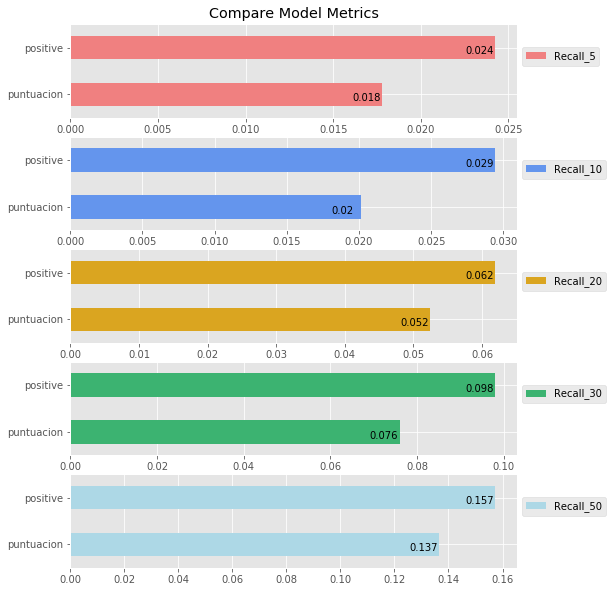

In [26]:
compare_model_metrics([puntuacion_m_r, positive_m_r], 'Recall')

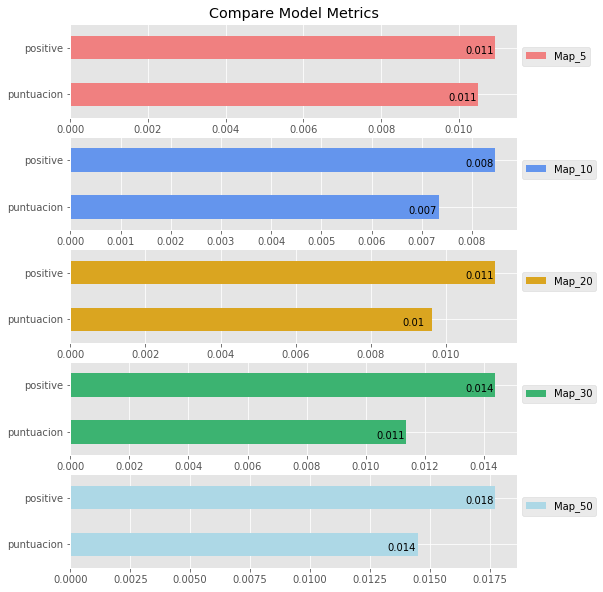

In [27]:
compare_model_metrics([puntuacion_m_r, positive_m_r], 'Map')

In [28]:
### MODELOS DE COOCURRENCIA

In [29]:
data_top=(data[data.rating>2])

In [30]:
data_untop=(data[data.rating<=2])

In [31]:
foodPerUser1 = (data_top.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [32]:
# Matriz de coocurrencia de los que le gustan
coMatrix_top = np.zeros((n_items, n_items))
for food in foodPerUser1.values():
    for x in food:
        coMatrix_top[x, food] += 1

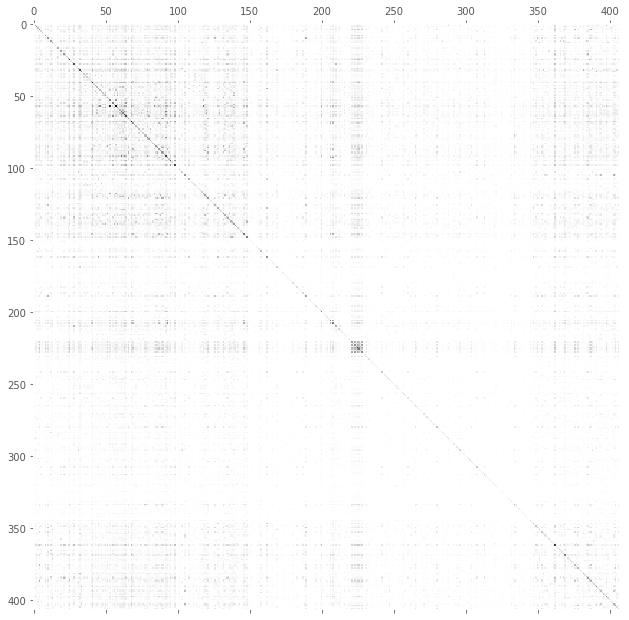

In [33]:
plt.matshow(coMatrix_top, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [34]:
foodPerUser2 = (data_untop.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [35]:
# # Matriz de coocurrencia de los que NO le gustan
coMatrix2 = np.zeros((n_items, n_items))
for food in foodPerUser2.values():
    for x in food:
        coMatrix2[x, food] += 1

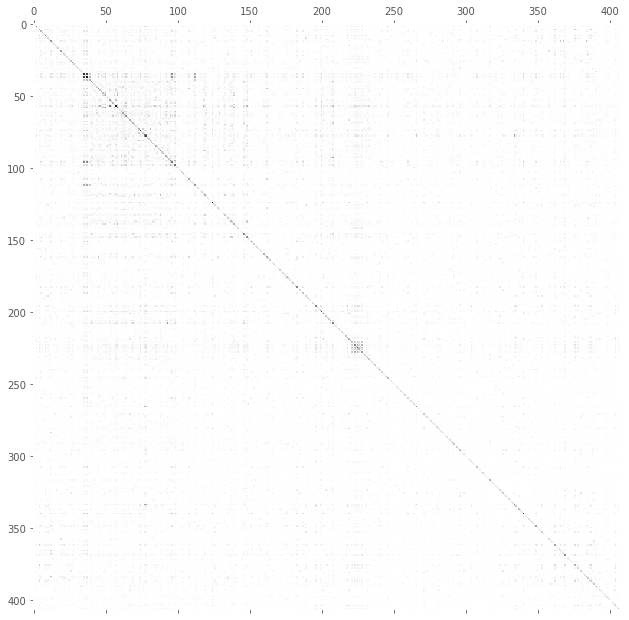

In [36]:
plt.matshow(coMatrix2, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

#Ntop similarity

In [37]:
train_top=(train[train.rating>2])

In [38]:
foodPerUser = (train_top.groupby('user_id')['items_id']
                 .apply(np.array)
                 .to_dict()
                )

In [39]:
coMatrix_top_train = np.zeros((n_items, n_items))
for food in foodPerUser.values():
    for x in food:
        coMatrix_top_train[x, food] += 1

In [40]:
coMatrix_top_train

array([[119.,   6.,  15., ...,  13.,   7.,   1.],
       [  6.,  76.,   7., ...,   2.,   3.,   0.],
       [ 15.,   7., 118., ...,   4.,   0.,   0.],
       ...,
       [ 13.,   2.,   4., ..., 109.,   6.,  16.],
       [  7.,   3.,   0., ...,   6.,  40.,   0.],
       [  1.,   0.,   0., ...,  16.,   0.,  50.]])

In [41]:
def co_occurrance_similarity(item_id, coocurrance, ntop=10):
    """
    Retorna los ntop más similares según la matriz coocurrencia
    """
    similarItems = coocurrance[item_id, :]
    mostSimilar = np.argsort(similarItems)[::-1]
    mostSimilar = mostSimilar[1:ntop+1]
    

    return np.stack((mostSimilar, similarItems[mostSimilar])).T

In [42]:
co_occurrance_similarity(122, coMatrix_top_train, 10)

array([[ 31.,  24.],
       [125.,  17.],
       [388.,  14.],
       [ 62.,  13.],
       [ 68.,  12.],
       [129.,  11.],
       [103.,  10.],
       [228.,  10.],
       [ 63.,  10.],
       [225.,   9.]])

In [43]:
column_items_id[122]

0

In [44]:
FoodId = 1
Ntop = 5
print('For item "%s" top-%s recommendations are:' % (food_id[FoodId], Ntop))

similarItems = co_occurrance_similarity(FoodId, coMatrix_top_train, Ntop)

for r in similarItems:
    print(int(r[0]), food_id[int(r[0])], r[1])

For item "Ensalada de tomate y pimiento asado" top-5 recommendations are:
398 Tortilla de Pimientos y Cebolla 41.0
288 Canelones con Verduras 33.0
25 Ensalada de maíz y aguacate 22.0
362 Verduras salteadas con soja 22.0
28 Ensalada de calabaza 21.0


In [45]:
def co_occurrance_recommendation(items_id, cooccurrance, ntop=10):
    """
    Devuelve la lista ntop recomendacciones, en base a un items_id y una matriz de coocurrencia
    
    """
    
    list_sim_items = np.vstack([co_occurrance_similarity(id_, cooccurrance, ntop) for id_ in items_id])
    
    largest_freq = pd.DataFrame(list_sim_items, columns=['id', 'freq']).groupby('id').agg(max).reset_index()
    
    sorted_list = largest_freq.sort_values(by='freq', ascending=False)
    
    out = sorted_list.values[:ntop, 0]
    return out
    

In [46]:
Ntop = 200

In [47]:
trainUsersGrouped = train.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
train_ids = trainUsersGrouped.items_id.values
testUsersGrouped = test.groupby('user_id')['items_id'].apply(list).reset_index().sort_index()
test_ids = testUsersGrouped.items_id.values

predictions = trainUsersGrouped.items_id.apply(lambda x: co_occurrance_recommendation(x, coMatrix_top_train, Ntop)).reset_index()
predictions.head()

,index,items_id
0,0,"[41.0, 68.0, 98.0, 50.0, 58.0, 95.0, 51.0, 85...."
1,1,"[41.0, 226.0, 98.0, 58.0, 51.0, 85.0, 225.0, 2..."
2,2,"[226.0, 68.0, 58.0, 95.0, 228.0, 223.0, 64.0, ..."
3,3,"[61.0, 63.0, 79.0, 208.0, 226.0, 228.0, 223.0,..."
4,4,"[57.0, 225.0, 223.0, 208.0, 118.0, 146.0, 221...."


In [48]:
len(predictions['items_id'][0])

200

In [49]:
topk = [5, 10, 20, 30, 50]
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****Recall_Map*****')
matriz_coocurrencia_m_r = m.metric('coocurrencia', topk)

*****Recall_Map*****
recall@5=0.218
recall@10=0.210
recall@20=0.303
recall@30=0.381
recall@50=0.494
map@5=0.255
map@10=0.192
map@20=0.192
map@30=0.208
map@50=0.223


In [50]:
testUsersGrouped['items_id'][10]

[25, 41, 71, 124, 147, 190, 225, 226, 258, 337, 355, 363, 377]

In [51]:
data.head()

,user_id,rating,comida,id_comida,items_id
0,18,3,Ensalada de col con queso,4,0
1,33,1,Ensalada de col con queso,4,0
2,63,1,Ensalada de col con queso,4,0
3,64,2,Ensalada de col con queso,4,0
4,65,1,Ensalada de col con queso,4,0


In [52]:
##  Jaccard similarity matrix

In [53]:
jaccard = np.zeros((n_items, n_items)) # Jaccard similarity matrix
for i, row in enumerate(coMatrix_top_train):
    if row[i]!=0: # Case where the diagonal is not empty, i.e. coM(i,i)!=0
        jaccard[i,:] = row/(row[i]+np.diag(coMatrix_top_train)-row)
    else: # case where the diagonal is empty. We have to aasign a similarity of 1 to item pairs without ratings
        for j in np.arange(n_items):
            if coMatrix_top_train[j,j]==0:
                jaccard[i,j] = 1.0
            else: 
                jaccard[i,j] = 0.0

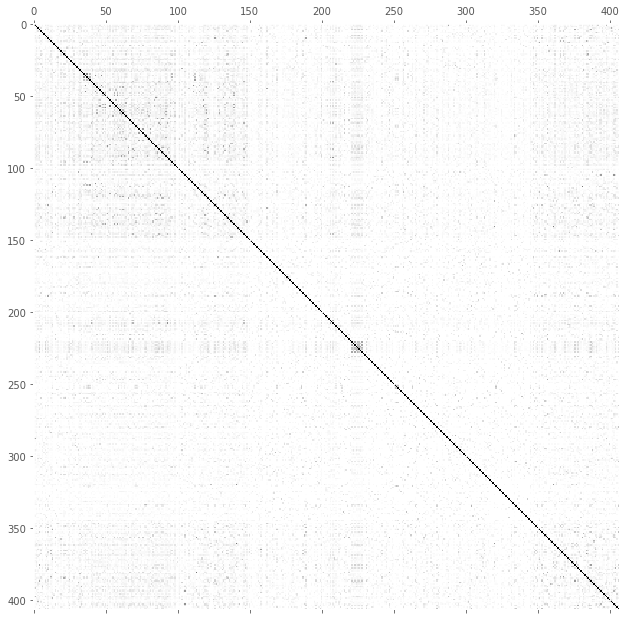

In [54]:
plt.matshow(jaccard, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [55]:
Ntop = 200
# Calculate the predictoins with Jaccard
predictions = trainUsersGrouped.items_id.apply(lambda x: co_occurrance_recommendation(x, jaccard, Ntop)).reset_index()
predictions.head()

,index,items_id
0,0,"[58.0, 50.0, 51.0, 85.0, 56.0, 139.0, 223.0, 2..."
1,1,"[58.0, 85.0, 51.0, 139.0, 223.0, 221.0, 228.0,..."
2,2,"[58.0, 56.0, 139.0, 50.0, 223.0, 228.0, 21.0, ..."
3,3,"[208.0, 61.0, 351.0, 13.0, 288.0, 40.0, 87.0, ..."
4,4,"[365.0, 208.0, 223.0, 221.0, 57.0, 88.0, 118.0..."


In [56]:
topk = [5, 10, 20, 30, 50]
predictions_ids = predictions.items_id.values
m = Metrics(train_ids, test_ids, predictions_ids)
print('*****Recall_Map*****')
jaccard_m_r = m.metric('jaccard',topk)

*****Recall_Map*****
recall@5=0.249
recall@10=0.245
recall@20=0.358
recall@30=0.473
recall@50=0.605
map@5=0.393
map@10=0.308
map@20=0.320
map@30=0.338
map@50=0.353


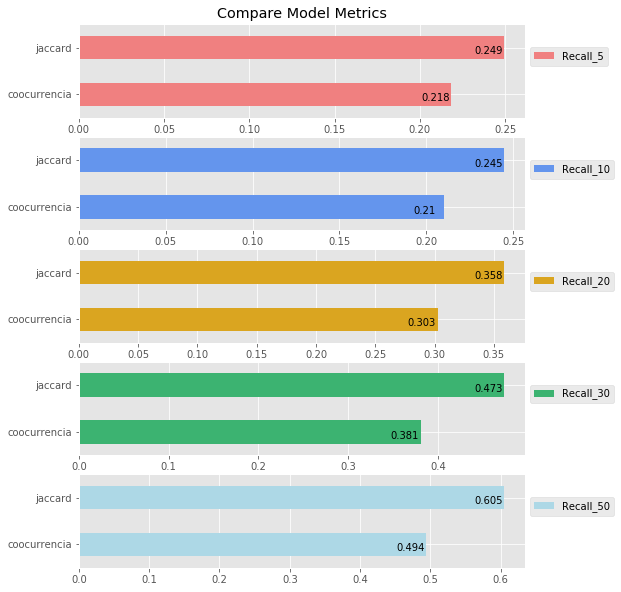

In [57]:
compare_model_metrics([matriz_coocurrencia_m_r, jaccard_m_r], 'Recall')

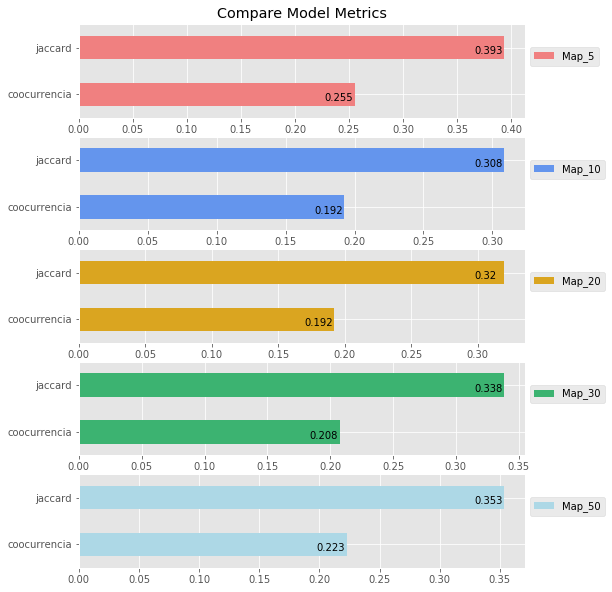

In [58]:
compare_model_metrics([matriz_coocurrencia_m_r, jaccard_m_r], 'Map')

In [59]:
# Memory Based in Collaborate Filter

In [60]:
uMatrixTraining = np.zeros((n_users, n_items)) # utility matrix
for row in train.values[:,0:5]:
    user = row[0]-1 #for use the same as index
    item = row[4]
    rating = row[1]
    uMatrixTraining[user, item] = rating

In [61]:
uMatrixTesting = np.zeros((n_users, n_items)) # utility matrix
for row in test.values[:,0:5]:
    # Note user ids start at 1
    user = row[0]-1
    item = row[4]
    rating = row[1]
    uMatrixTesting[user, item] = rating

In [62]:
def cosineSimilarity(ratings, kind='user', epsilon=1e-9):
    """
    Calculate the cosine distance along the row (columns) of a matrix for users (items)
    
    :param ratings: a n_user X n_items matrix
    :param kind: string indicating whether we are in mode 'user' or 'item'
    :param epsilon: a small value to avoid dividing by zero (optional, defaults to 1e-9)
    
    :return a square matrix with the similarities
    """
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T)+epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings)+epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T


USER - USER

In [63]:
userSimilarity = cosineSimilarity(uMatrixTraining, kind='user')

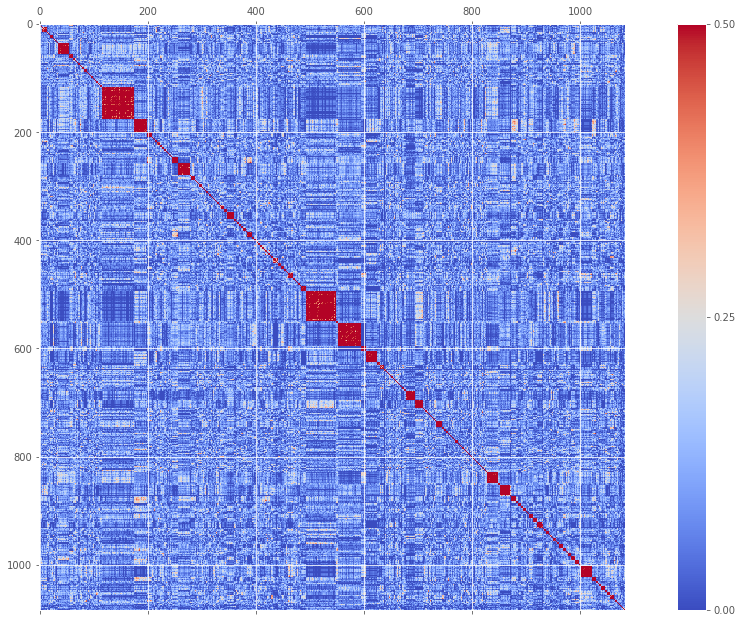

In [64]:
cax = plt.matshow(userSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [65]:
norm = np.array([userSimilarity.sum(axis=1)]).T
userItemCFpredictions = userSimilarity.dot(uMatrixTraining) / norm

### Item-Item

In [66]:
itemSimilarity = cosineSimilarity(uMatrixTraining, kind='item')

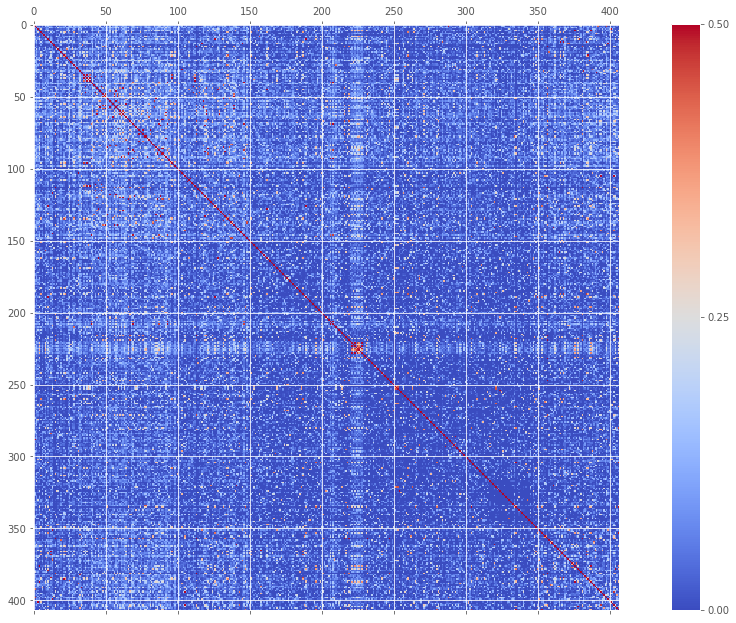

In [67]:
cax = plt.matshow(itemSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [68]:
itemItemCFpredictions = uMatrixTraining.dot(itemSimilarity)/np.array([np.abs(itemSimilarity).sum(axis=1)])

In [69]:
query_Id = 300
print("Selected item is '%s'" % food_id[query_Id])


queryAnswer = np.argsort(itemSimilarity[query_Id,:])[::-1][1:]

Ntop = 10
print("Most %d similar food are:" %Ntop)
printAnswer = queryAnswer[0:Ntop]
for answerId in printAnswer:
    print(food_id[answerId]+", with similarity %.2f" %itemSimilarity[query_Id, answerId])

Selected item is 'Raviolis rellenos de setas'
Most 10 similar food are:
Raviolis con salsa de nueces, with similarity 0.20
Ternera asada con patatas nuevas, with similarity 0.18
Ragout de Ternera, with similarity 0.17
Espaguetis integrales con verduras, with similarity 0.17
Puré de coliflor con queso, with similarity 0.16
Arroz frito con curry, with similarity 0.16
Puré de Arvejas o Guisantes, with similarity 0.16
Ensalada de Espinacas y Champiñones, with similarity 0.15
Estofado de cerdo con manzanas, with similarity 0.15
Ensaladilla rusa para el verano, with similarity 0.14


In [70]:
itemItemCFpredictions[uMatrixTraining>=2.0] = 0.0
for u in np.random.randint(0, n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Items: ")
    seen = uMatrixTesting[u,:]
    print([food_id[i] for i,r in enumerate(seen) if r>2.0])
    print("Recommended items: ")
    recom = itemItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([food_id[i] for i in recom])

******
User 424
Items: 
['Conejo a la parrilla', 'Redondo de Ternera con Setas', 'Lomo de cerdo en salsa de manzana', 'Setas al horno', 'Pastel de champiñones', 'Pastel de Puerros y Champiñones', 'Empanadas argentinas', 'Carne en salsa fácil', 'Ñoquis con espinacas', 'Tortilla con setas']
Recommended items: 
['Raviolis de Queso', 'Canelones de berenjena rellenos de carne', 'Pizza con piña hawaiana', 'Pastel de Puerros y Champiñones', 'Espaguetis de calabacín con salsa de tomate', 'Setas al horno', 'Pastel de champiñones', 'Acelgas salteadas con patata', 'Pizza de polenta sin gluten y vegana', 'Ñoquis con espinacas']
******
User 764
Items: 
['Cordero con Salsa Teriyaki', 'Estofado de Ternera en Olla Express', 'Solomillo en salsa roquefort', 'Sopa de avena y verduras', 'Empanadas argentinas', 'Quiche de espinacas', 'Tortilla de Espárragos Verdes']
Recommended items: 
['Pizza con base de remolacha', 'Fetuccini a la napolitana', 'Muslos de Pollo Frito', 'Arroz frito con ternera', 'Ensalada

In [71]:
userItemCFpredictions[uMatrixTraining>=2.0] = 0.0
for u in np.random.randint(0, n_users, 3):
    print("*"*6)
    print("User %s" % u)
    print("Seen items: ")
    seen = uMatrixTesting[u,:]
    print([food_id[i] for i,r in enumerate(seen) if r>2.0])
    print("Recommended items: ")
    recom = userItemCFpredictions[u,:]
    recom = np.argsort(recom)[::-1][:10]
    print([food_id[i] for i in recom])

******
User 46
Seen items: 
['Ensalada de repollo y zanahoria', 'Chuletas de cerdo con salsa mostaza', 'Solomillo de cerdo al horno', 'Solomillo en salsa roquefort', 'Chorizo con papas', 'Raviolis rellenos de espinacas', 'Canelones de carne picada y Bechamel', 'Verduras salteadas con soja', 'Revuelto de espinacas']
Recommended items: 
['Churrasco a la brasa', 'Chorizo con papas', 'Estofado de Ternera en Olla Express', 'Ternera a la jardinera', 'Verduras salteadas con soja', 'Ensalada de maíz y aguacate', 'Guiso de ternera con garbanzos', 'Estofado de Ternera con Verduras', 'Solomillo en salsa roquefort', 'Ensaladilla rusa para el verano']
******
User 948
Seen items: 
['Acelgas con Patatas y Pimentón', 'Ensalada de Pepino', 'Chuletas de cordero asadas', 'Pollo en salsa de soja y miel', 'Ragout de Ternera', 'Pierna de cordero al horno', 'Wrap de lechuga con atún', 'Pizza pepperoni', 'Tortilla de brócoli y coliflor', 'Tortilla de rúcula']
Recommended items: 
['Alambre de res con champiñon

In [72]:
from math import sqrt
def rmse(prediction, ground_truth):
    """
    Return the Root Mean Squared Error of the prediction
    """
    r, c = ground_truth.nonzero()
    p = prediction[r,c]
    t = ground_truth[r,c]
    return sqrt(np.mean(np.power(p-t, 2.0)))

In [73]:
print('User-based CF RMSE=%.3f' %rmse(userItemCFpredictions, uMatrixTesting))

User-based CF RMSE=2.781


In [74]:
print('Item-based CF RMSE=%.3f' %rmse(itemItemCFpredictions, uMatrixTesting))

Item-based CF RMSE=2.809


In [75]:
itemItemCFpredictions_sorted = np.argsort(itemItemCFpredictions)[:, ::-1]

test_ids = testUsersGrouped.items_id.values
train_ids = trainUsersGrouped.items_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: itemItemCFpredictions_sorted[i-1]).values
topk = [5, 10, 20, 30, 50]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall_Map*****')
item_item_m_r = m.metric('itemitem',topk)

*****Recall_Map*****
recall@5=0.403
recall@10=0.388
recall@20=0.490
recall@30=0.571
recall@50=0.672
map@5=0.463
map@10=0.393
map@20=0.396
map@30=0.413
map@50=0.429


In [76]:
userItemCFpredictions_sorted = np.argsort(userItemCFpredictions)[:, ::-1]

test_ids = testUsersGrouped.items_id.values
train_ids = trainUsersGrouped.items_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: userItemCFpredictions_sorted[i-1]).values
topk = [5, 10, 20, 30, 50]
m = Metrics(train_ids, test_ids, predicted_ids)
print('*****Recall_Map*****')
user_item_m_r = m.metric('useritem',topk)

*****Recall_Map*****
recall@5=0.336
recall@10=0.308
recall@20=0.417
recall@30=0.504
recall@50=0.595
map@5=0.297
map@10=0.241
map@20=0.262
map@30=0.279
map@50=0.293


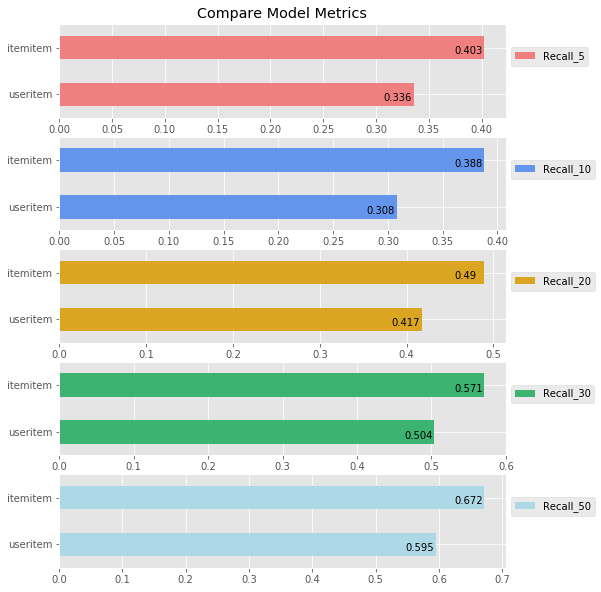

In [77]:
compare_model_metrics([item_item_m_r, user_item_m_r], 'Recall')

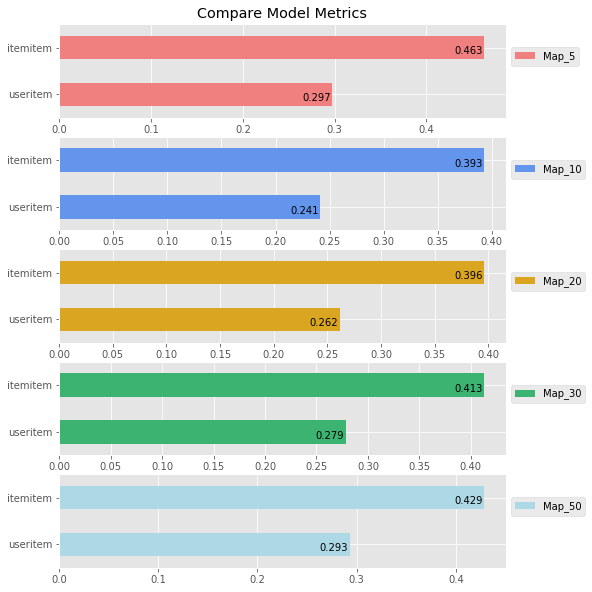

In [78]:
compare_model_metrics([item_item_m_r, user_item_m_r], 'Map')

In [79]:
#Comparacion de Todas las métricas

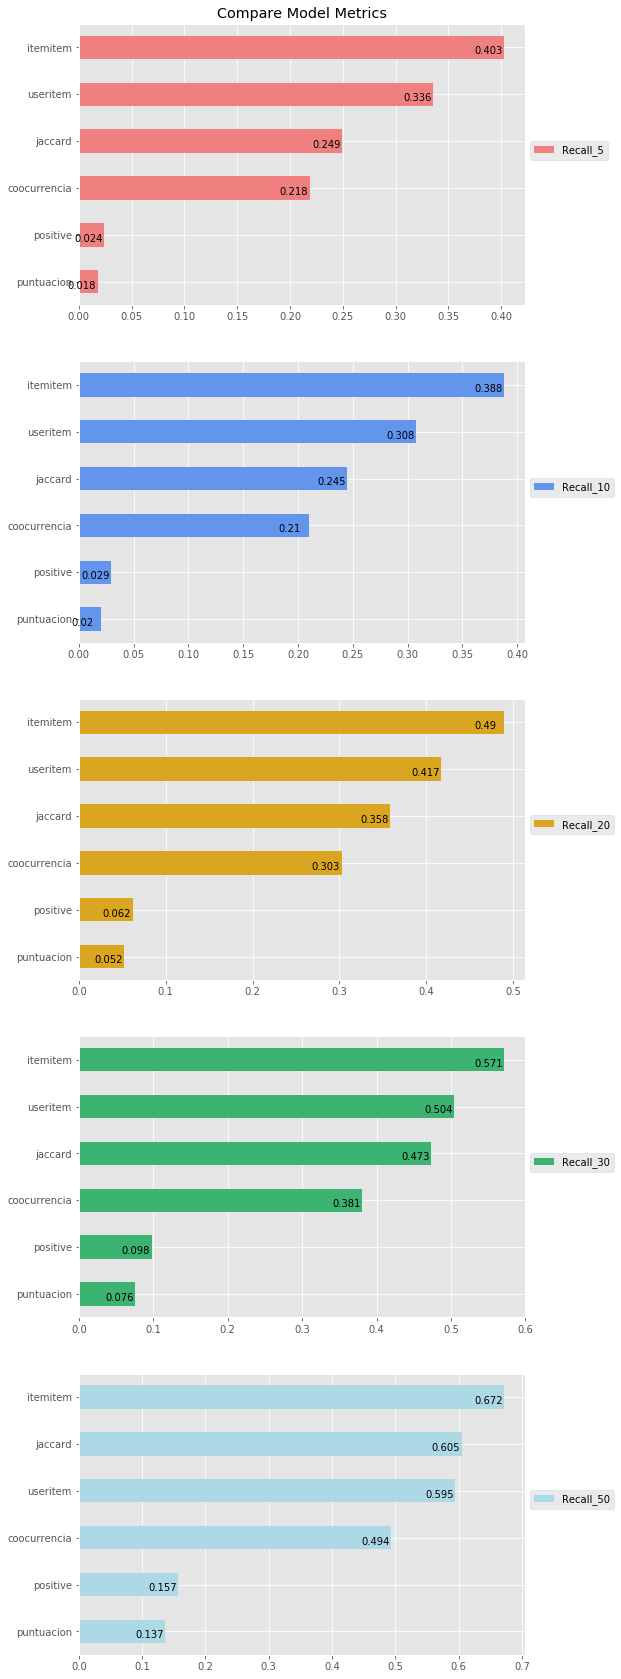

In [80]:
compare_model_metrics([puntuacion_m_r, positive_m_r,matriz_coocurrencia_m_r, jaccard_m_r, item_item_m_r, user_item_m_r], 'Recall')

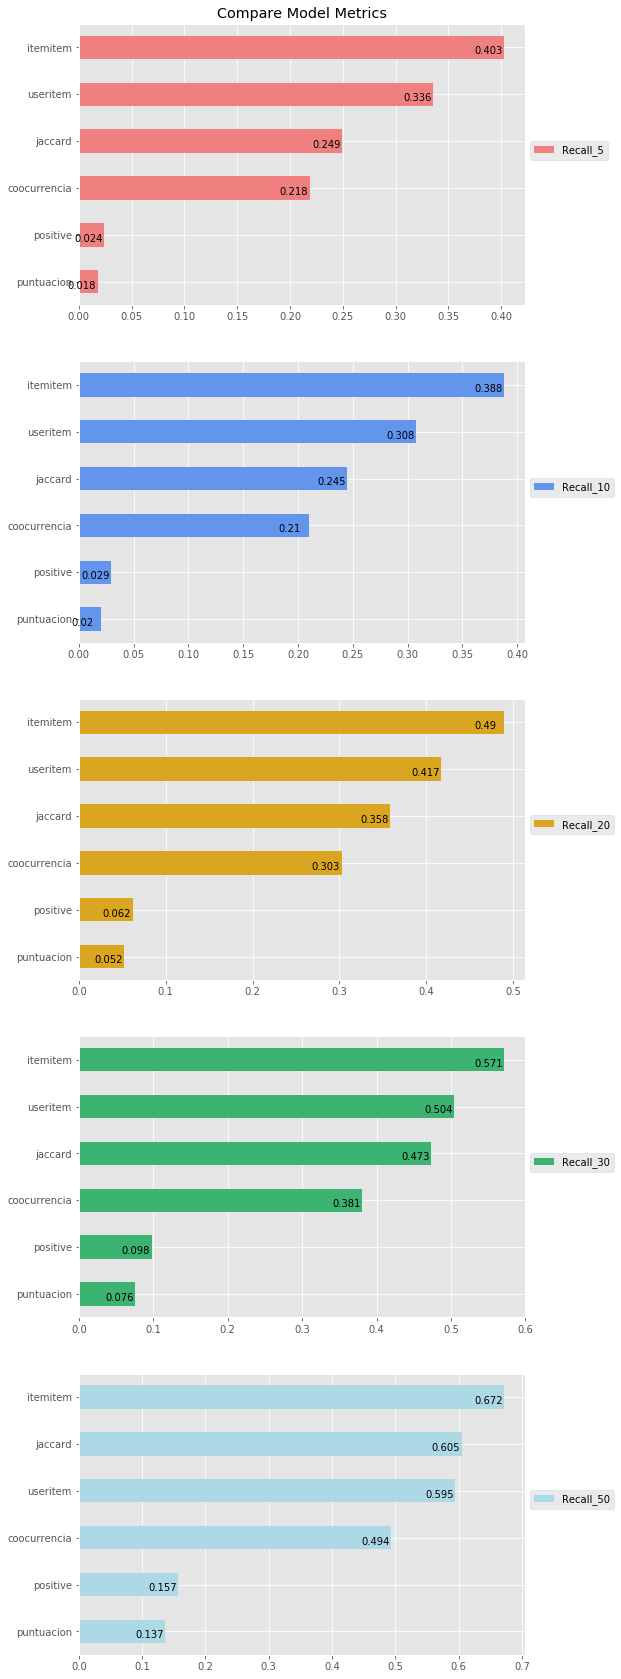

In [81]:
compare_model_metrics([puntuacion_m_r, positive_m_r,matriz_coocurrencia_m_r, jaccard_m_r, item_item_m_r, user_item_m_r], 'Recall')